# Objektdefinition

## 1. Importe

Zuerst importieren wir ein paar benötigte Pakete.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
%matplotlib inline

from standard_config import *
import sys

sys.path.append("{}/utils/io".format(local_home_path))
import file_io as fio
import io_config as ioc

sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import glob
from ipywidgets import *

from skimage.morphology import h_minima
from scipy import ndimage as ndi

from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)

import MSGtools as mst
import pandas as pd

import fixed_colourbar as fc

# 2. Beispielfall

Danach laden wir uns einen Beispielfall, versuchen ein Objekt zu finden und analysieren die Minimumtemepratur im IR-10,8-µm-Feld über die Zeit.

## 2.1 Beispielfall laden

In [2]:
haci_cases = glob.glob("{}/*.nc".format(ioc.haci_track_data_path))

In [3]:
example_case = fio.read_nc_file(haci_cases[100])

In [4]:
def plot_haci_case(case_data):
    from plotting_tools.colormaps import enhanced_colormap2
    emap = enhanced_colormap2(vmin=210,vmed1=240,vmed2=270,vmax=300)
    
    from plotting_tools.colormaps import radar_cmap as rc
    
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].pcolormesh(case_data['slon'],case_data['slat'],ir,vmin=210,vmax=300,cmap=emap)
        p1 = axs[i].contourf(case_data['rlon'],
                             case_data['rlat'],
                             np.ma.masked_greater(np.ma.masked_less(case_data['rx'][i],5),70),
                             np.arange(5,75,5),
                             vmin=5,vmax=70,cmap=rc(),
                             alpha=0.5)
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                       unit='m',
                                                                       timezone='UTC'),
                                         (i*5) - 30))

    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'RX / dBZ')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig           

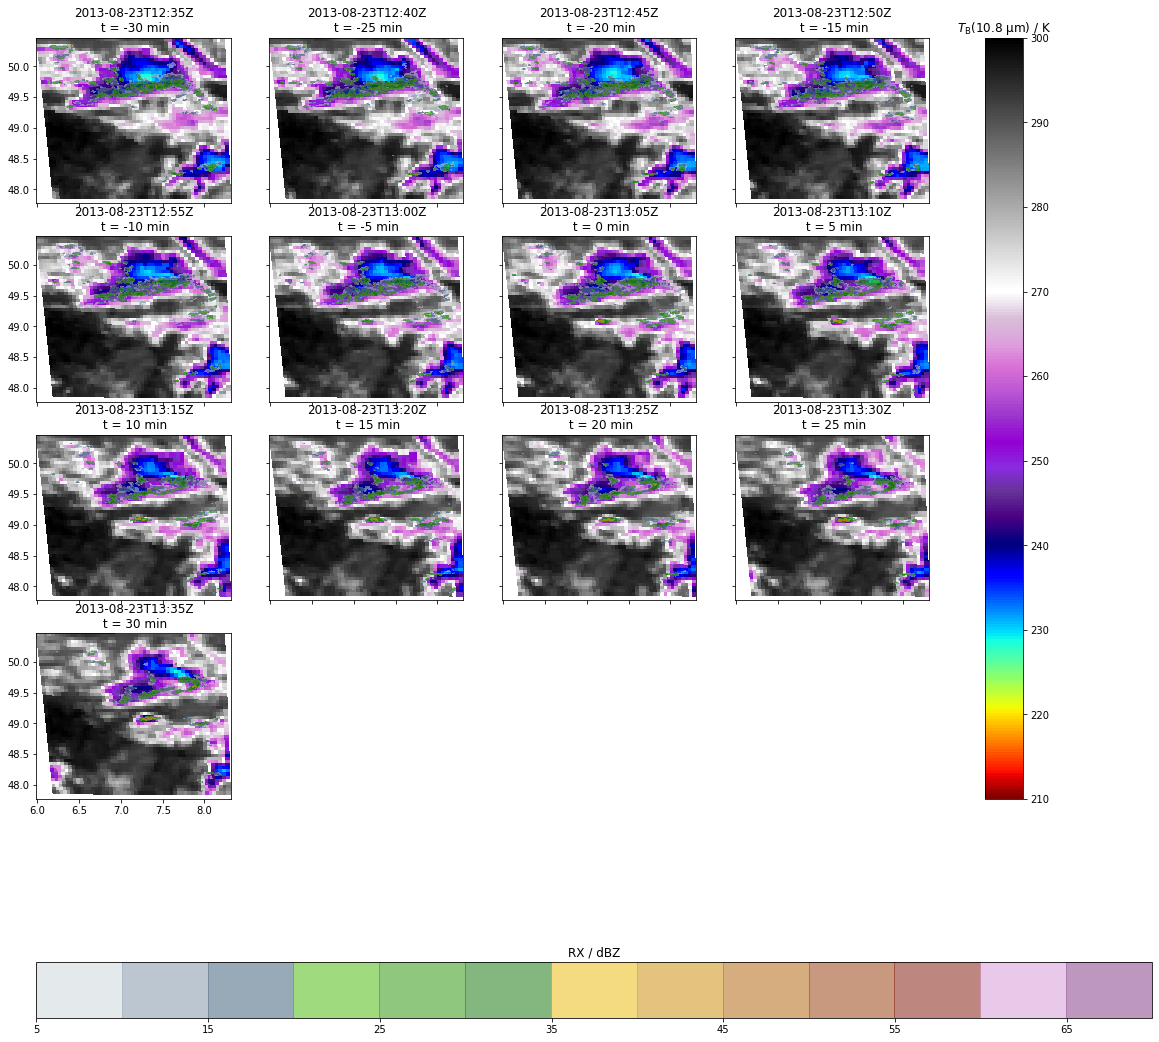

In [5]:
fig = plot_haci_case(example_case)

Das sieht doch gar nicht so schlecht aus. Es ist kein Fall bei dem viel passiert, aber eine vernüftige Objektdefinition sollte möglich sein.

In [136]:
case_objects = np.array([oseg.segment_local_threshold(ir,3,273.15,220,240,5) for ir in example_case['ir108']])

In [137]:
def plot_case_object(case_data,object_data):
        
    fig,ax = plt.subplots(4,4,figsize=(20,20),sharex=True,sharey=True)
    axs = ax.ravel()

    for i,ir in enumerate(case_data['ir108']):
        p = axs[i].imshow(ir,vmin=210,vmax=300,cmap='gray_r')
        p1 = axs[i].imshow(np.ma.masked_less(object_data[i],1),alpha=0.6,vmin=1,vmax=np.max(object_data))
        
        axs[i].set_title("{}\n t = {} min".format(np.datetime_as_string(case_data['time'][i],
                                                                        unit='m',
                                                                        timezone='UTC'),
                                                  (i*5) - 30)
                                                 )
    cbar1 = fig.colorbar(p1, ax=ax.flat,orientation='horizontal')
    cbar1.ax.set_title(u'Objektnummer')

    cbar = fig.colorbar(p, ax=ax.flat)
    cbar.ax.set_title(r'$T_\mathrm{B}$(10.8 µm) / K')
    
    fig.delaxes(axs[13])
    fig.delaxes(axs[14])
    fig.delaxes(axs[15])
                         
    return fig           

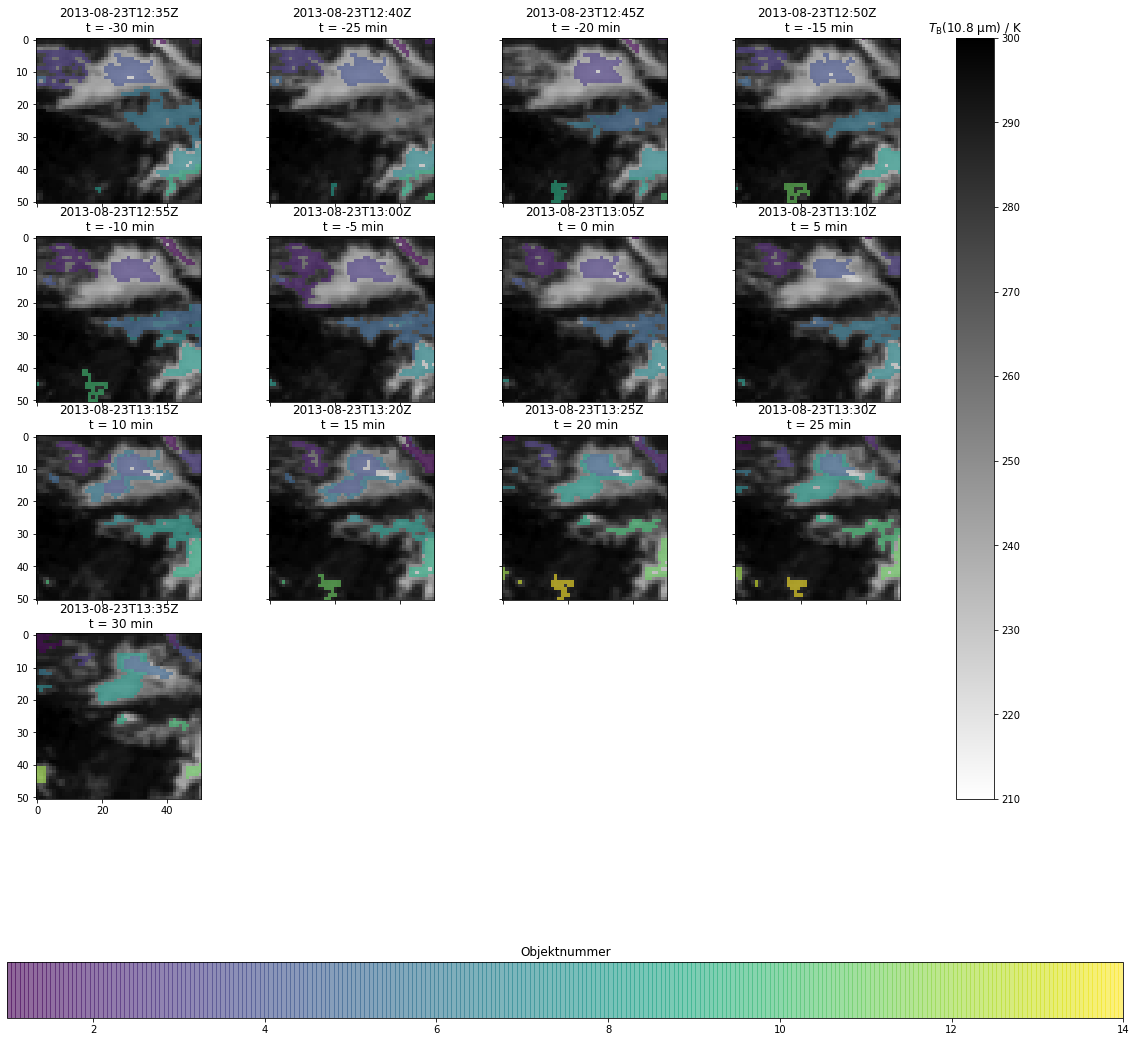

In [138]:
fig = plot_case_object(example_case,case_objects)

In [119]:
from importlib import reload

In [153]:
reload(oseg)

<module 'segmentation' from '/vols/satellite/home/lenk/utils/tracking/segmentation.py'>

In [155]:
@interact
def plot_object_definitions(t = (0,12),depth=(0,20),spread=(0,25),t_min=(180,240),t_max=(240,300),t_level=(200,270)):
    #case_object = np.array([oseg.segment_local_threshold(ir,depth,t_max,t_min,t_level,spread) for ir in example_case['ir108']])
    case_object = oseg.segment_local_threshold(example_case['ir108'][t],depth,t_max,t_min,t_level,spread,0,300)
    #plot_case_object(example_case,case_object)
    
    lmins = h_minima(example_case['ir108'][t],depth)
    lmins_labeled = ndi.label(lmins)[0]
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(example_case['ir108'][t],vmin=210,vmax=300,cmap='gray_r')#,cmap=emap)
    ax.imshow(np.ma.masked_less(case_object,1),cmap='nipy_spectral',alpha=0.8)
    #ax.contour(case_object,np.unique(case_object)[1:],cmap='inferno')    
    #ax.imshow(np.ma.masked_less(lmins,1),alpha=0.8,cmap='Reds')
    
    for lm in np.unique(lmins_labeled):
        lm_loc = np.where(lmins_labeled==lm)
        ax.plot(np.min(lm_loc[1]),np.min(lm_loc[0]),'r+')
        ax.text(np.min(lm_loc[1]),
                np.min(lm_loc[0]),
                "{:.1f} K".format(np.unique(example_case['ir108'][t][lm_loc])[0]),c='r')

interactive(children=(IntSlider(value=6, description='t', max=12), IntSlider(value=10, description='depth', ma…

In [130]:
field = example_case['ir108'][6]

In [131]:
minima = h_minima(field,7)

In [132]:
local_minima_field, nlabels = oseg.get_labeled_local_minima(field,7,0)

In [133]:
minima_label = np.arange(1,nlabels)

In [134]:
tlimit= 260

In [139]:
# create dictionary to store the values of the local minima
minima_values = {ml:[] for ml in minima_label}

# collect the position and the values of the local minima
for ml in minima_label:
    ml_location = np.where(local_minima_field==ml)

    if np.all(local_minima_field[ml_location[0][0],ml_location[1][0]] < tlimit): 
        minima_values[ml] = [ml_location[0][0], 
                             ml_location[1][0],
                             field[ml_location][0],
                             oseg.local_threshold(field[ml_location][0])]
    else:
        continue

In [140]:
minima_values

{1: [0, 39, 239.2945, 253.39981410630293],
 2: [8, 11, 258.601, 272.7987600940734],
 3: [11, 35, 228.69480000000001, 240.0],
 4: [13, 4, 256.5158, 271.3792077207902],
 5: [14, 9, 263.67810000000003, 275.5709522180621],
 6: [26, 24, 252.37310000000002, 268.07353577403575],
 7: [27, 40, 253.5797, 269.10299826735655],
 8: [39, 48, 231.79520000000002, 242.0823897828787],
 9: [45, 1, 270.1137, 277.69091029746],
 10: [46, 19, 282.192, 287.192],
 11: [47, 46, 235.52640000000002, 247.97778406472253]}

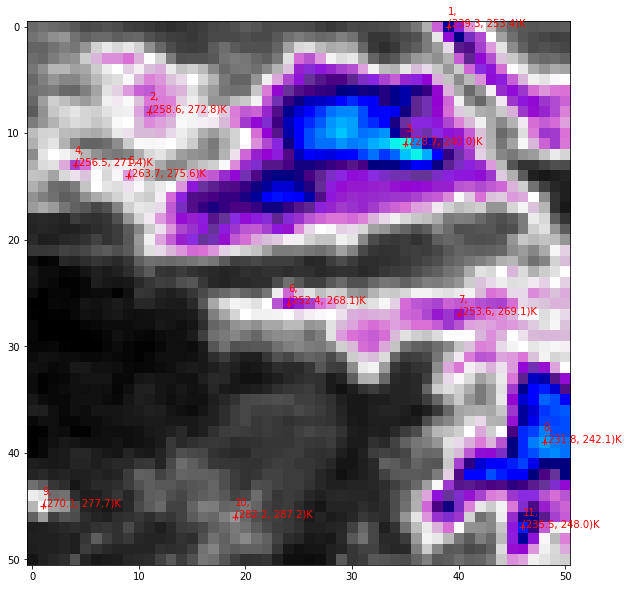

In [143]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap=emap)

for m in minima_values.keys():
    ax.plot(minima_values[m][1],
            minima_values[m][0],'r+')
    ax.text(minima_values[m][1],
            minima_values[m][0],
            "{},\n({:.1f}, {:.1f})K".format(m,minima_values[m][2],minima_values[m][3]),c='r')

In [144]:
local_minimum = 6

In [145]:
minima_values[local_minimum]

[26, 24, 252.37310000000002, 268.07353577403575]

In [146]:
lower_mask = np.ma.masked_less(field,minima_values[local_minimum][3])
upper_mask = np.ma.masked_greater_equal(field,minima_values[local_minimum][2])

In [147]:
def range_colourmap(vmin=210,vthresh=240,vlmin=270,vmax=300):
    nfull = 256

    nwarm = int(np.rint(nfull * (vmax - vlmin) / (vmax - vmin)))
    nright = int(np.rint(nfull * (vlmin - vthresh) / (vmax - vmin)))
    ncool = nfull - ngray1 - ncol

      
    colors1 = plt.cm.gray_r(np.linspace(0., 1., nwarm))
    colors2 = plt.cm.Wistia_r(np.linspace(0.,1.,nright))
    colors3 = plt.cm.cool_r(np.linspace(0, 1., ncool))

    # combine them and build a new colormap
    colors = np.vstack((colors3,colors2, colors1))
    mymap = mcolor.LinearSegmentedColormap.from_list('object_cmap', colors)


    return mymap

In [148]:
rmap = range_colourmap(vmin = 210,
                       vthresh = minima_values[local_minimum][2],
                       vlmin = minima_values[local_minimum][3],
                       vmax = 300)

Text(0.5, 1.0, 'für Objekt in Frage\nkommende Bereiche')

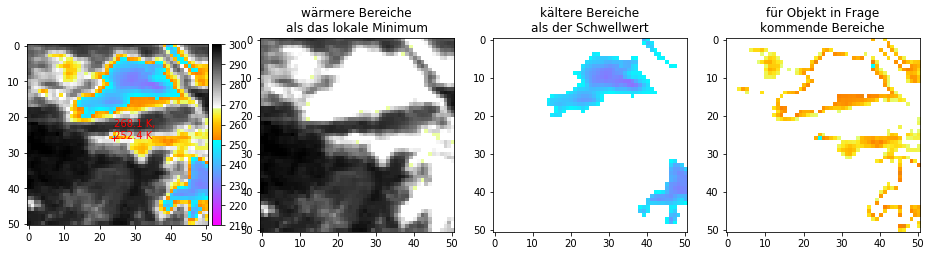

In [149]:
fig,ax = plt.subplots(1,4,figsize=(16,4))
p = ax[0].imshow(example_case['ir108'][6],
                 vmin=210,
                 vmax=300,
                 cmap=rmap)
fc.colourbar(p)
ax[0].plot(minima_values[local_minimum][1],
           minima_values[local_minimum][0],'r+')
ax[0].text(minima_values[local_minimum][1],
           minima_values[local_minimum][0],
            "{:.1f} K,\n{:.1f} K".format(minima_values[local_minimum][3],
                                        minima_values[local_minimum][2]),c='r')

ax[1].imshow(lower_mask,
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[1].set_title("wärmere Bereiche\nals das lokale Minimum")

ax[2].imshow(upper_mask,
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[2].set_title("kältere Bereiche\nals der Schwellwert")
ax[3].imshow(np.ma.masked_where(lower_mask.mask & upper_mask.mask == False,example_case['ir108'][6]),
             vmin=210,
             vmax=300,
             cmap=rmap)
ax[3].set_title("für Objekt in Frage\nkommende Bereiche")

In [98]:
threshold_mask = upper_mask.mask & lower_mask.mask

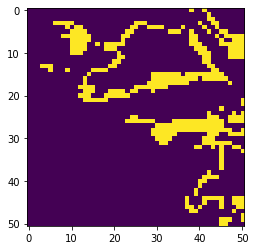

In [99]:
plt.imshow(threshold_mask)

In [100]:
threshold_mask_labeled = ndi.label(threshold_mask*1)[0]

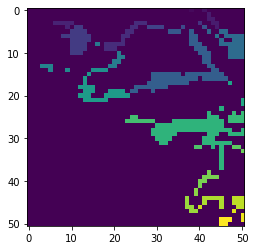

In [101]:
plt.imshow(threshold_mask_labeled)

In [102]:
obj_id = np.unique(threshold_mask_labeled[minima_values[local_minimum][0],
                                          minima_values[local_minimum][1]])

In [103]:
obj_id

array([28], dtype=int32)

In [104]:
obj_location = np.where(threshold_mask_labeled==obj_id)

In [105]:
obj_location

(array([25, 25, 26, 26, 26, 26, 26, 26, 26]),
 array([24, 25, 23, 24, 25, 26, 27, 28, 29]))

In [117]:
# calculate the local threshold for the local minima and store them
segmented_field = np.zeros_like(field,dtype="uint16")


for local_minimum in minima_values.keys():
    if np.isnan(minima_values[local_minimum][3]):
        continue
    else:
        # create masks with areas which inbetween the thresholds
        lower_mask = np.ma.masked_less(field,minima_values[local_minimum][3])
        upper_mask = np.ma.masked_greater_equal(field,minima_values[local_minimum][2])
        
        #threshold_mask = np.ma.masked_less_equal(field,
        #                                         minima_values[local_minimum][3]).mask*1 

        threshold_mask = upper_mask.mask & lower_mask.mask
        # label those areas
        threshold_mask_labeled = ndi.label(threshold_mask*1)[0]

        # get label for the wanted object
        obj_id = np.unique(threshold_mask_labeled[minima_values[local_minimum][0],
                                                  minima_values[local_minimum][1]])#[0]

        # get the points of this object
        obj_location = np.where(threshold_mask_labeled==obj_id)
        
        # check, if there is already an object
        segment_values = np.unique(segmented_field[obj_location])
        
        # if all are zero, we simply label these values as belonging to the object
        if np.all(segment_values == 0):
            segmented_field[obj_location] = local_minimum
        # if not we only label those values, which are zero
        else:
            zero_loc = np.where(segmented_field[obj_location]==0)
            loc = (obj_location[0][zero_loc],obj_location[1][zero_loc])
            segmented_field[loc] = local_minimum

In [113]:
obj_location

(array([10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14,
        14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16,
        16, 17, 17, 17, 18, 18, 18, 19, 20, 20, 21, 21, 21]),
 array([ 1,  2,  1,  2,  1,  2,  3,  4,  1,  2,  3,  6,  7,  8,  9, 10,  3,
         4,  5,  6,  7,  8,  9, 10,  6,  7,  8,  9, 10, 11, 12, 13,  9, 10,
        12, 10, 11, 12, 10, 11, 12, 12, 11, 12, 11, 12, 13]))

In [116]:
obj_location[0][zero_loc]

array([10, 10, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14, 14,
       14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18,
       18, 18, 19, 20, 20, 21, 21, 21])

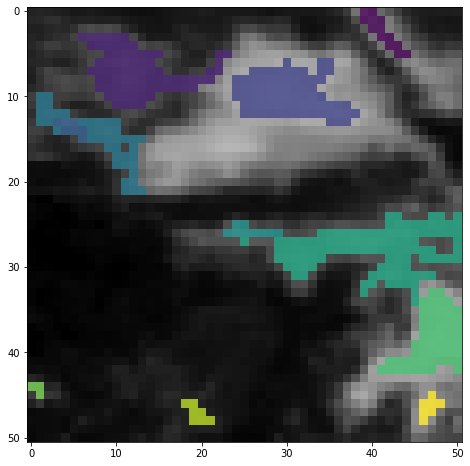

In [118]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(field,vmin=210,vmax=300,cmap='gray_r')
ax.imshow(np.ma.masked_less(segmented_field,1),alpha=0.8)

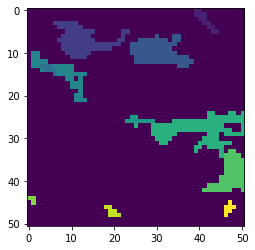

In [156]:
plt.imshow(oseg.segment_local_threshold(field,
                                        minimum_depth = 7,
                                        tmax = 273.15,
                                        tmin = 220,
                                        thresh_min = 240,
                                        spread = 10,
                                        tlimit=300))

In [13]:
from scipy import ndimage as ndi
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

In [160]:
test_mins = h_minima(example_case['ir108'][6],7)

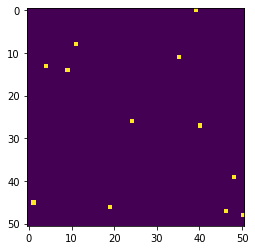

In [161]:
plt.imshow(test_mins)

In [162]:
test_mins_labeled = ndi.label(test_mins)[0]

In [163]:
values = {label:{'value':[],'threshold':[],'column':[],'row':[]} for label in np.unique(test_mins_labeled)[1:]}
threshold_map = np.full_like(example_case['ir108'][6],300)

for label in np.unique(test_mins_labeled)[1:]:
    label_loc = np.where(test_mins_labeled==label)
    thresh = oseg.local_threshold(example_case['ir108'][6][label_loc])
    
    values[label]['threshold'] = thresh#[0]
    values[label]['value'] = example_case['ir108'][6][label_loc][0]
    values[label]['column'] = label_loc[0][0]
    values[label]['row'] = label_loc[1][0]
    threshold_map[label_loc] = thresh#[0]

In [164]:
values

{1: {'value': 239.2945,
  'threshold': array([253.39981411]),
  'column': 0,
  'row': 39},
 2: {'value': 258.601,
  'threshold': array([272.79876009]),
  'column': 8,
  'row': 11},
 3: {'value': 228.69480000000001, 'threshold': 240, 'column': 11, 'row': 35},
 4: {'value': 256.5158,
  'threshold': array([271.37920772]),
  'column': 13,
  'row': 4},
 5: {'value': 263.67810000000003,
  'threshold': array([275.57095222]),
  'column': 14,
  'row': 9},
 6: {'value': 252.37310000000002,
  'threshold': array([268.07353577]),
  'column': 26,
  'row': 24},
 7: {'value': 253.5797,
  'threshold': array([269.10299827]),
  'column': 27,
  'row': 40},
 8: {'value': 231.79520000000002,
  'threshold': array([242.08238978]),
  'column': 39,
  'row': 48},
 9: {'value': 270.1137,
  'threshold': array([277.6909103]),
  'column': 45,
  'row': 1},
 10: {'value': 282.192,
  'threshold': array([287.192]),
  'column': 46,
  'row': 19},
 11: {'value': 235.52640000000002,
  'threshold': array([247.97778406]),
  '

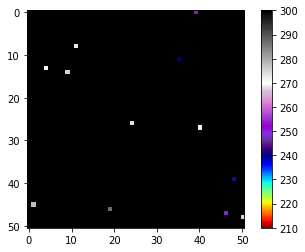

In [165]:
plt.imshow(threshold_map,vmin=210,vmax=300,cmap=emap)
plt.colorbar()

In [166]:
from skimage.morphology import watershed

In [167]:
segmented = watershed(example_case['ir108'][6],test_mins_labeled)

In [168]:
masks = []
for label in values.keys():
    mask = np.zeros_like(example_case['ir108'][6])
    
    mask = np.ma.masked_where(example_case['ir108'][6]< values[label]['threshold'],mask)
    
    masks.append(mask.mask)

In [169]:
maske = ~np.ma.masked_less(np.sum(masks,axis=0),1).mask

In [170]:
len(masks)

12

In [171]:
cma = mst.get_nwcsaf_prod("CMa",pd.Timestamp(example_case['time'][6]).to_pydatetime(),calibrate=True)

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l2_nwcsaf/eu/2013/08/23/SAFNWC_MSG?_CMa__201308231305_rss-eu______.c?.h5  does not exist!


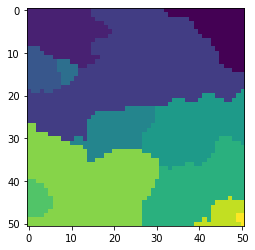

In [172]:
plt.imshow(segmented)

In [173]:
seg2 = watershed(example_case['ir108'][6],test_mins_labeled,mask=np.ma.masked_greater(example_case['cma'][6],1).mask)

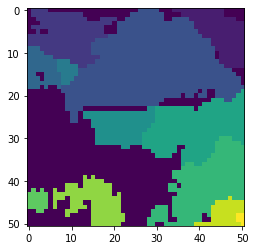

In [174]:
plt.imshow(seg2)

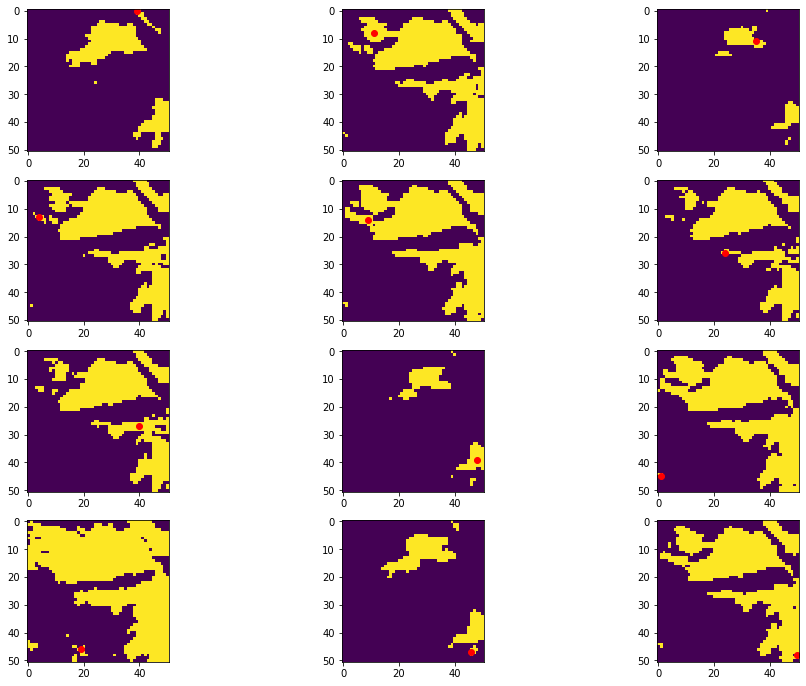

In [175]:
fig, ax = plt.subplots(4,3,figsize=(16,12))
axs = ax.ravel()

for i,m in enumerate(masks):
    axs[i].imshow(m)
    min_loc = np.where(test_mins_labeled==i+1)
    axs[i].plot(min_loc[1],min_loc[0],'ro')

Vielleicht ist es eine gute Idee nur die Bereiche, in denen das lokale Minimum liegt in die Maske aufzunehmen.

In [178]:
masks2 = [ ]
for label in values.keys():
    mask = np.zeros_like(example_case['ir108'][6])
    mask = np.ma.masked_where(example_case['ir108'][6] < values[label]['threshold'],mask)
    
    m_labeled = ndi.label(mask.mask*1)[0]
    min_label = m_labeled[values[label]['column'],values[label]['row']]
    
    omask = np.full_like(example_case['ir108'][6],False)
    omask[np.where(m_labeled==min_label)] = True
    
    masks2.append(omask)

In [179]:
label = 1

In [180]:
mask = np.zeros_like(example_case['ir108'][6])
mask = np.ma.masked_where(example_case['ir108'][6]< values[label]['threshold'],mask)

In [181]:
m_labeled = ndi.label(mask.mask*1)[0]

In [182]:
min_label = m_labeled[values[label]['column'],values[label]['row']]

In [183]:
min_label

1

In [184]:
mask = np.full_like(example_case['ir108'][6],False)

In [185]:
mask[np.where(m_labeled==min_label)] = True

In [186]:
np.where(m_labeled==min_label)

(array([0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5]),
 array([39, 40, 39, 40, 41, 40, 41, 41, 42, 42, 43, 43, 44]))

(30, 0)

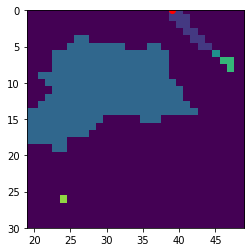

In [187]:
plt.imshow(m_labeled)
plt.plot(values[label]['row'],values[label]['column'],'ro')
plt.xlim(19,49)
plt.ylim(30,0)
#plt.colorbar()

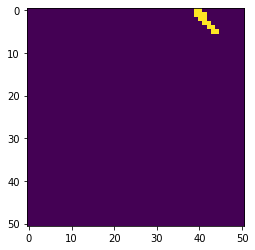

In [188]:
plt.imshow(mask)

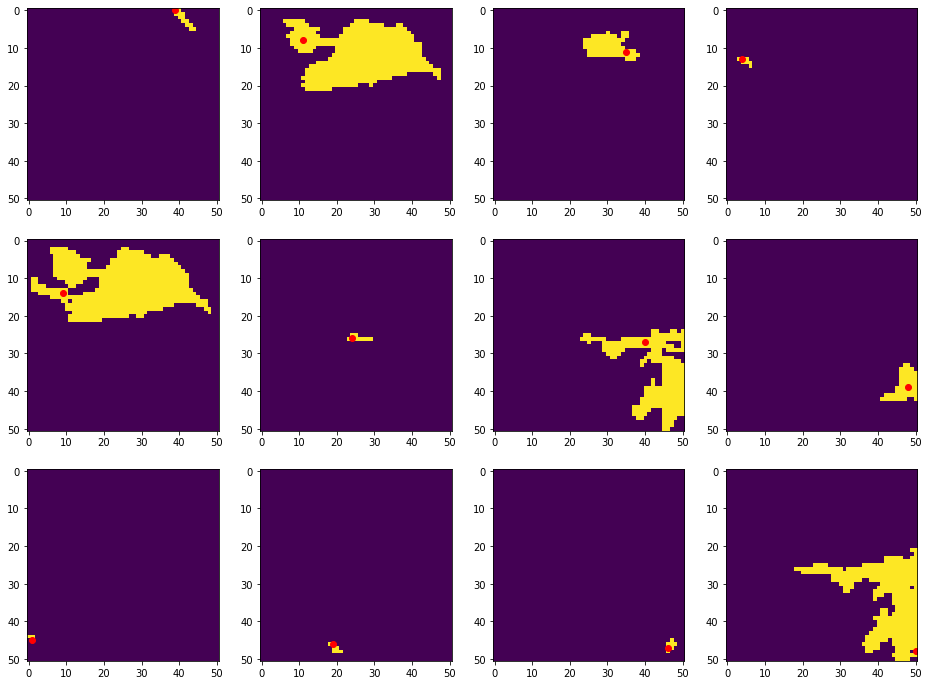

In [189]:
fig, ax = plt.subplots(3,4,figsize=(16,12))
axs = ax.ravel()

for i,m in enumerate(masks2):
    axs[i].imshow(m)
    min_loc = np.where(test_mins_labeled==i+1)
    axs[i].plot(min_loc[1],min_loc[0],'ro')

Damit könnte man sich wahrscheinlich die ganze Watershed-Transformation sparen. Aber mal sehen.

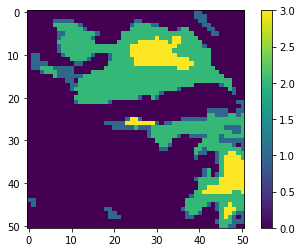

In [190]:
plt.imshow(np.sum(masks2,axis=0))
plt.colorbar()

In [191]:
maske2 = np.sum(masks2,axis=0)

In [199]:
segmented2 = watershed(example_case['ir108'][6], test_mins_labeled, mask=maske2)#, watershed_line=True)
case_object = oseg.segment_local_threshold(example_case['ir108'][6],6,273.15,220,240,5,0)

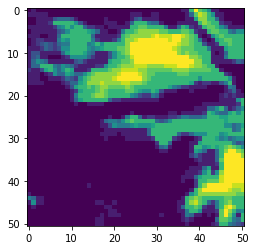

In [193]:
plt.imshow(np.sum(masks,axis=0))

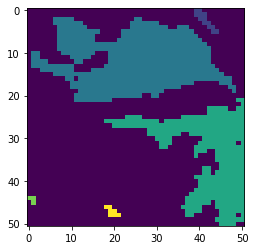

In [194]:
plt.imshow(ndi.label(maske2)[0])

Text(0.5, 1.0, 'Methode mit Watershed')

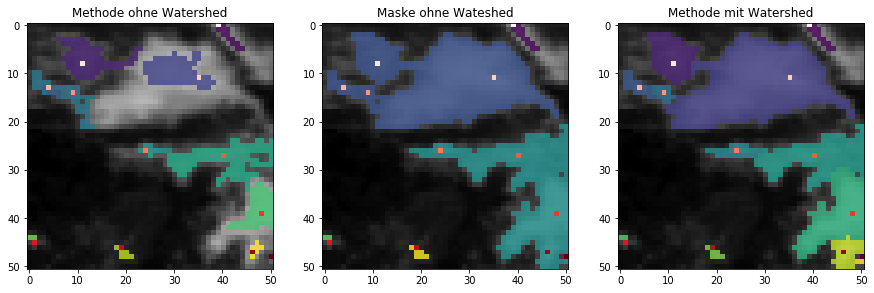

In [200]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(case_object,1),alpha=0.8)
ax[0].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[0].set_title("Methode ohne Watershed")

ax[1].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(ndi.label(maske2)[0],1),alpha=0.8)
ax[1].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[1].set_title("Maske ohne Wateshed")

ax[2].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[2].imshow(np.ma.masked_less(segmented2,1),alpha=0.8)
ax[2].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[2].set_title("Methode mit Watershed")

Bei der Methode ohne Watershed werden, wie zu erwarten die Kernbereiche der Wolke selektiert. Wenn allerdings Bereiche in mehreren Objekten liegen könnten, ist die Zuordnung mehr oder weniger Zufall. Bei der Methode mit der Watershedsegmentierung werden viel zu große Bereiche ausgewählt. Da läuft bei der Maskenbildung etwas gründlich schief. Um die Zuordnung der Objekte aber bei der ersten Methode zu verbessern, könnte man die Objektzuordungen als Maske für eine folgende Watershedsegmentierung nehmen und so beide Ansätze kombinieren.

In [203]:
combined = watershed(example_case['ir108'][6], test_mins_labeled, mask=np.ma.masked_greater(case_object,0).mask)

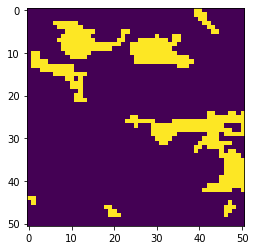

In [202]:
plt.imshow(np.ma.masked_greater(case_object,0).mask)

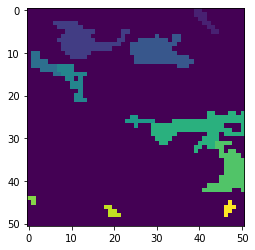

In [204]:
plt.imshow(combined)

In [205]:
mask3 = np.zeros_like(maske2)
for i,oid in enumerate(np.unique(segmented2)[1:]):
    oloc = np.where(segmented2==oid)
    
    oids_prev = np.unique(maske2[oloc])
    
    if len(oids_prev) > 1:
        oid_right_loc = np.where(maske2==np.unique(test_mins_labeled)[1:][i])
        mask3[oid_right_loc] = i+1
        print("mehrere")
    else:
        mask3[oloc] = i+1
        print("einzeln")
        
    print(i,oid,oids_prev)

einzeln
0 1 [1.]
mehrere
1 2 [1. 2.]
mehrere
2 3 [1. 2. 3.]
mehrere
3 4 [1. 2.]
einzeln
4 5 [1.]
mehrere
5 6 [1. 2. 3.]
mehrere
6 7 [1. 2.]
mehrere
7 8 [1. 2. 3.]
einzeln
8 9 [1.]
einzeln
9 10 [1.]
mehrere
10 11 [1. 2. 3.]
einzeln
11 12 [1.]


In [102]:
test_mins_labeled[i]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int32)

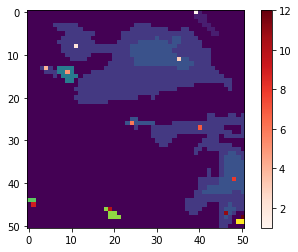

In [109]:
plt.imshow(mask3)
plt.imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
plt.colorbar()

Text(0.5, 1.0, 'Maskenunterschied')

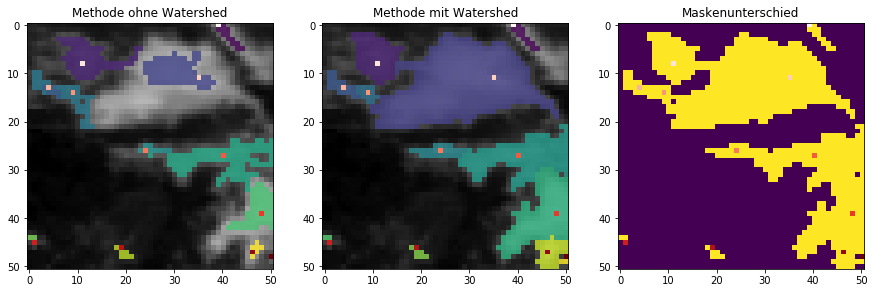

In [206]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(case_object,1),alpha=0.8)
ax[0].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[0].set_title("Methode ohne Watershed")

ax[1].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(segmented2,1),alpha=0.8)
ax[1].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[1].set_title("Methode mit Watershed")


ax[2].imshow(example_case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')
ax[2].imshow(np.ma.masked_greater(maske2,0).mask*1 + np.ma.masked_greater(segmented2,0).mask*1)
ax[2].imshow(np.ma.masked_less(test_mins_labeled,1),cmap='Reds')
ax[2].set_title("Maskenunterschied")

In [207]:
combined_mask = maske2 + segmented2

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


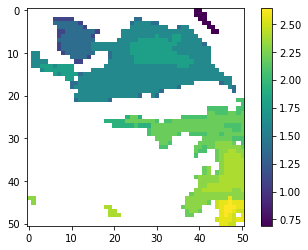

In [208]:
plt.imshow(np.log(maske2 + segmented2))
plt.colorbar()

In [209]:
mask_value = []
m = np.zeros_like(test_mins_labeled)
for i,l in enumerate(np.unique(test_mins_labeled)[1:]):
    print(l)
    loc = np.where(test_mins_labeled==l)
    mask_value.append(combined_mask[loc])
    m[np.where(combined_mask==l)] = i+1

1
2
3
4
5
6
7
8
9
10
11
12


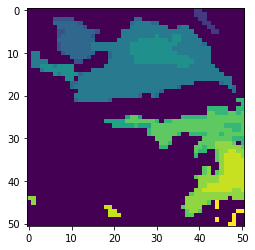

In [210]:
plt.imshow(m)

In [211]:
combined_mask[np.where(test_mins_labeled==l)]

array([13.])

In [212]:
np.where(test_mins_labeled==l)]

SyntaxError: invalid syntax (<ipython-input-212-58b72e4d8ae3>, line 1)

In [213]:
mask_value

[array([2.]),
 array([4.]),
 array([6.]),
 array([6.]),
 array([6.]),
 array([9.]),
 array([9.]),
 array([11.]),
 array([10.]),
 array([11.]),
 array([14.]),
 array([13.])]

In [74]:
def get_lmin_properties(labeled_local_minima,data_array,tmin=220,tmax=273.15,tlevel=240,spread=5):
    # extract labels of local minima
    lmin_labels = np.unique(labeled_local_minima)[1:]
    
    # collect local values, threshold values and location of the local minima
    properties = {label:{'value':[],
                         'threshold':[],
                         'column':[],
                         'row':[]} for label in lmin_labels}

    for label in lmin_labels:
        label_loc = np.where(labeled_local_minima==label)
        
        if label_loc[0].size > 1:
            label_loc = (np.array([np.min(label_loc[0])]), np.array([np.min(label_loc[1])]))
            
        thresh = oseg.local_threshold(data_array[label_loc],tmax,tmin,tlevel,spread)

        properties[label]['threshold'] = thresh#[0]
        properties[label]['value'] = data_array[label_loc][0]
        properties[label]['column'] = label_loc[0][0]
        properties[label]['row'] = label_loc[1][0]
        
    return properties

def create_mask_from_thresholds(labeled_local_minima,lmin_properties,data_array):
    label_masks = [ ]
        
    for label in lmin_properties.keys():
        # mask where data values are below threshold
        mask = np.zeros_like(labeled_local_minima)
        mask = np.ma.masked_where(data_array < lmin_properties[label]['threshold'],mask)

        # label those areas
        m_labeled = ndi.label(mask.mask*1)[0]
        min_label = m_labeled[lmin_properties[label]['column'],lmin_properties[label]['row']]

        # select that area, where the local minimum is located inside
        omask = np.full_like(data_array,False)
        omask[np.where(m_labeled==min_label)] = True

        # append to list of maksk
        label_masks.append(omask)
        
    # combine masks
    label_mask =  np.ma.masked_greater(np.sum(label_masks,axis=0),0).mask
    
    # return combined mask
    return label_mask

def watershed_local_min_segmentation(data_array, depth=6, tmin=220, tmax=273.25, tlevel=240):
    from skimage.morphology import h_minima, watershed
    from scipy import ndimage
    
    # find local minima
    local_mins = h_minima(data_array, depth)
    
    # label the local minima
    lmins_labeled = ndi.label(local_mins)[0]
    
    # collect local values, threshold values and locations of the local minima
    lmin_properties = get_lmin_properties(lmins_labeled,data_array)
        
    # get mask with possible object locations
    mask = create_mask_from_thresholds(lmins_labeled,lmin_properties,data_array)
    
    # perform watershed transformation with the local minima as markers using the mask
    watershed_segmentation = watershed(data_array, lmins_labeled, mask=mask, watershed_line=False)
    
    # return segmented field
    return watershed_segmentation

In [216]:
reload(oseg)

<module 'segmentation' from '/vols/satellite/home/lenk/utils/tracking/segmentation.py'>

In [221]:
objects_ws = []

for i in range(len(example_case['ir108'])):
    objects = oseg.watershed_local_min_segmentation(example_case['ir108'][i],7,220,273.15,240,5,0)
    objects_ws.append(objects)

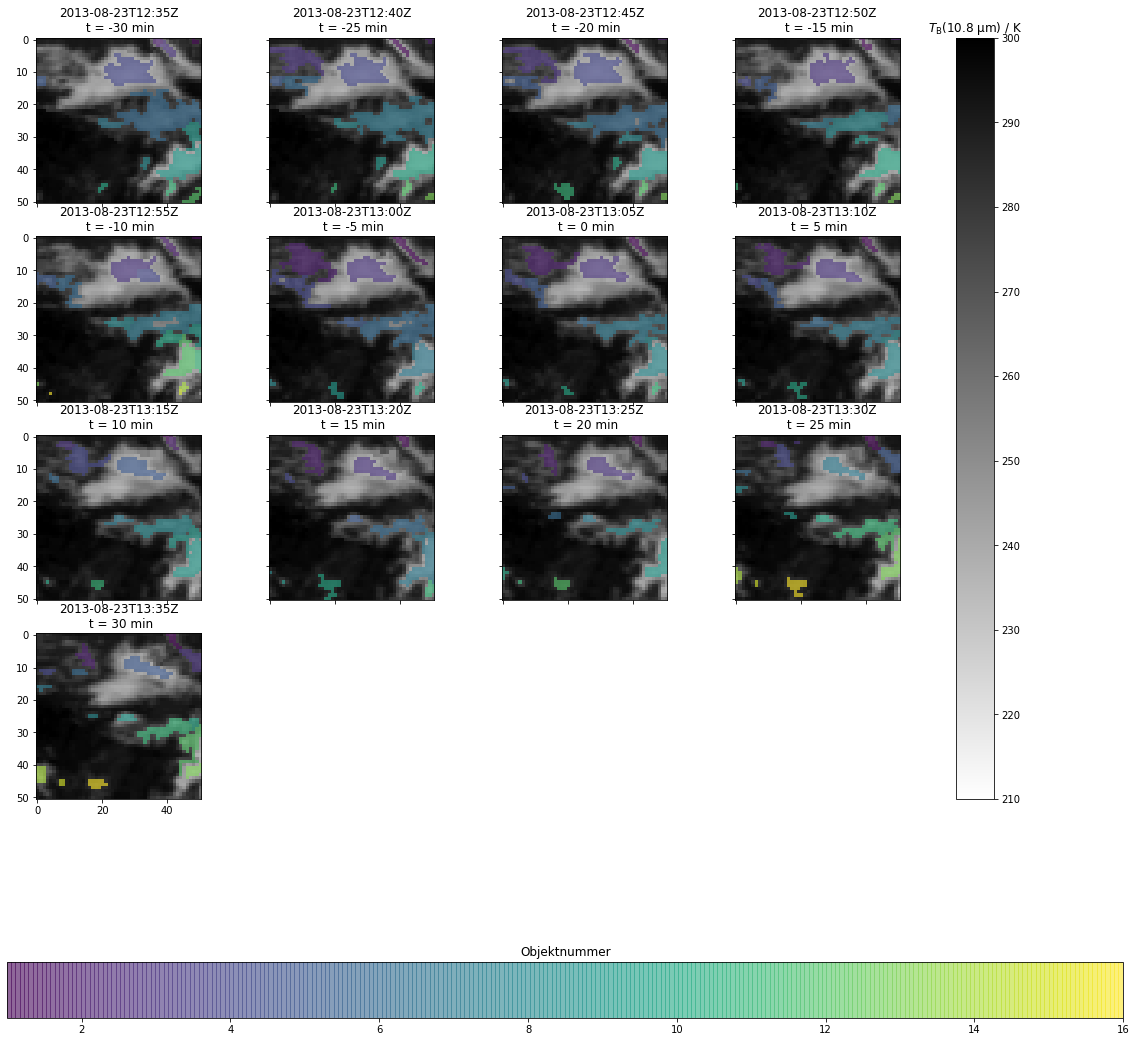

In [222]:
fig = plot_case_object(example_case,objects_ws)

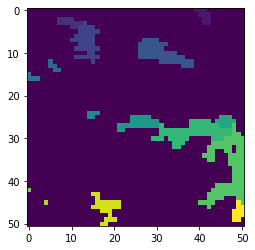

In [223]:
plt.imshow(oseg.watershed_local_min_segmentation(example_case['ir108'][9],6,220,273.15,240,5,0))

In [224]:
data_array = example_case['ir108'][6]

In [26]:
from skimage import filters

In [86]:
from importlib import reload

In [91]:
reload(oseg)

<module 'segmentation' from '/vols/satellite/home/lenk/utils/tracking/segmentation.py'>

In [225]:
local_mins = h_minima(data_array,6)

# label the local minima
lmins_labeled = ndi.label(local_mins)[0]

# collect local values, threshold values and locations of the local minima
lmin_properties = oseg.get_lmin_properties(lmins_labeled,data_array)

# get mask with possible object locations
mask = oseg.create_mask_from_thresholds(lmins_labeled,lmin_properties,data_array)

# create mask using Otsu's approach to fix some problems
otsu_mask = np.ma.masked_greater(data_array,
                                 filters.threshold_otsu(data_array))

# combine masks
mask = ~otsu_mask.mask & mask

NameError: name 'filters' is not defined

In [93]:
lmin_properties

{1: {'value': 239.2945,
  'threshold': 253.39981410630293,
  'column': 0,
  'row': 39},
 2: {'value': 258.601, 'threshold': 272.7987600940734, 'column': 8, 'row': 11},
 3: {'value': 228.69480000000001, 'threshold': 240, 'column': 11, 'row': 35},
 4: {'value': 256.5158,
  'threshold': 271.3792077207902,
  'column': 13,
  'row': 4},
 5: {'value': 263.67810000000003,
  'threshold': 275.5709522180621,
  'column': 14,
  'row': 9},
 6: {'value': 252.37310000000002,
  'threshold': 268.07353577403575,
  'column': 26,
  'row': 24},
 7: {'value': 253.5797,
  'threshold': 269.10299826735655,
  'column': 27,
  'row': 40},
 8: {'value': 231.79520000000002,
  'threshold': 242.0823897828787,
  'column': 39,
  'row': 48},
 9: {'value': 270.1137, 'threshold': 277.69091029746, 'column': 45, 'row': 1},
 10: {'value': 282.192, 'threshold': 287.192, 'column': 46, 'row': 19},
 11: {'value': 235.52640000000002,
  'threshold': 247.97778406472253,
  'column': 47,
  'row': 46},
 12: {'value': 262.0801,
  'thres

In [94]:
label_masks = [ ]

for label in lmin_properties.keys():
    # mask where data values are below threshold
    mask = np.zeros_like(lmins_labeled)
    mask = np.ma.masked_where(data_array < lmin_properties[label]['threshold'],mask)

    # label those areas
    m_labeled = ndi.label(mask.mask*1)[0]
    min_label = m_labeled[lmin_properties[label]['column'],lmin_properties[label]['row']]

    # select that area, where the local minimum is located inside
    omask = np.full_like(data_array,False)
    omask[np.where(m_labeled==min_label)] = True

    # append to list of maksk
    label_masks.append(omask)

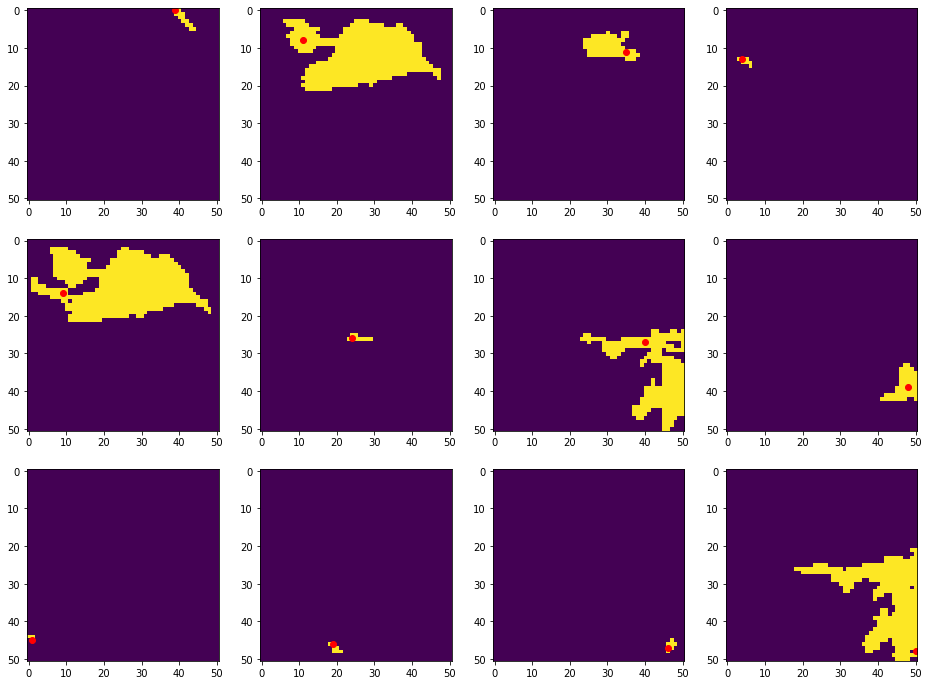

In [95]:
fig,ax = plt.subplots(3,4,figsize=(16,12))
axs= ax.ravel()
for i,m in enumerate(label_masks):
    axs[i].imshow(m)
    axs[i].plot(lmin_properties[i+1]['row'],lmin_properties[i+1]['column'],'ro')

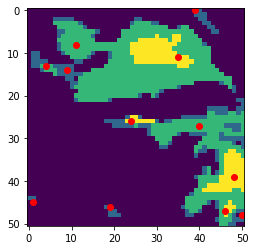

In [96]:
plt.imshow(np.sum(label_masks,axis=0))

for label in lmin_properties:
    plt.plot(lmin_properties[label]['row'],lmin_properties[label]['column'],'ro')

In [97]:
lmins= local_mins

In [98]:
mask_sum = np.sum(label_masks,axis=0)

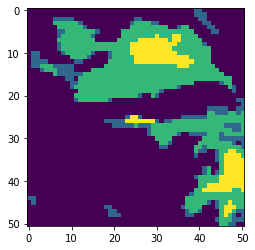

In [99]:
plt.imshow(mask_sum)

In [100]:
level1 = np.ma.masked_equal(mask_sum,1).mask
level1_labeled = ndi.label(level1*1)[0]

In [101]:
level1_mask = np.zeros_like(mask_sum)

In [102]:
level1_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:
lmin_mask = np.ma.masked_greater(lmins,0).mask

In [104]:
represented_lmins = lmin_mask & level1

In [105]:
rlmins_loc = np.where(represented_lmins==True)

In [106]:
rlmins_loc

(array([ 0, 14, 45, 46, 48]), array([39,  9,  1, 19, 50]))

In [107]:
retained_objects = level1_labeled[rlmins_loc]

In [108]:
retained_objects

array([ 1, 20, 52, 55, 59], dtype=int32)

In [109]:
for ro in retained_objects:
    obj_loc = np.where(level1_labeled==ro)
    
    level1_mask[obj_loc]=1

In [110]:
np.where(level1_labeled==ro)

(array([47, 47, 48, 48, 49, 49, 49, 50, 50]),
 array([49, 50, 48, 50, 48, 49, 50, 47, 48]))

In [111]:
level1_mask[obj_loc]

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

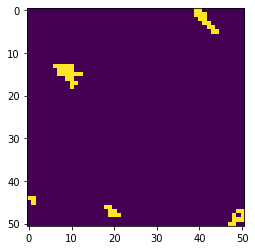

In [112]:
plt.imshow(level1_mask)

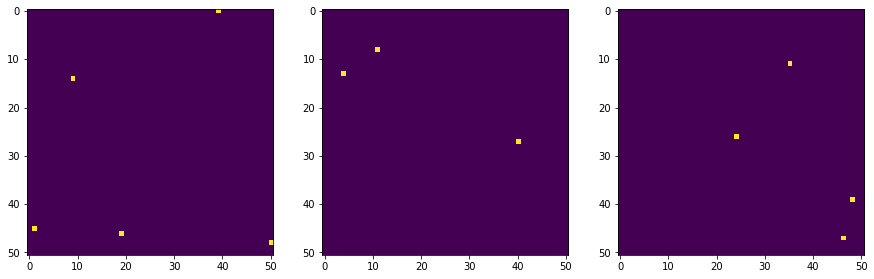

In [113]:
lmin_mask = np.ma.masked_greater(lmins_labeled,0).mask
level_masks = []

fig,ax = plt.subplots(1,3,figsize=(15,5))
for i,level in enumerate(np.unique(mask_sum)[1:]):
    level_mask = np.ma.masked_equal(mask_sum,level).mask
   
    level_labeled = ndi.label(level_mask*1)[0]

    level_objects = np.zeros_like(level_mask)

    # check, which local minima are located within objects at this level
    represented_lmins = lmin_mask & level_mask

    ax[i].imshow(represented_lmins)
    # collect values of those objects
    retained_objects = level_labeled[np.where(represented_lmins==True)]

    for ro in retained_objects:
        obj_loc = np.where(level_labeled==ro)

        level_mask[obj_loc]=1

    level_masks.append(level_mask)

In [114]:
level = 1

In [115]:
level_mask = np.ma.masked_equal(mask_sum,level).mask
   
level_labeled = ndi.label(level_mask*1)[0]

level_objects = np.zeros_like(level_mask)

# check, which local minima are located within objects at this level
represented_lmins = lmin_mask & level_mask

retained_objects = level_labeled[np.where(represented_lmins==True)]

for ro in retained_objects:
    level_objects[np.where(level_labeled==ro)]=1

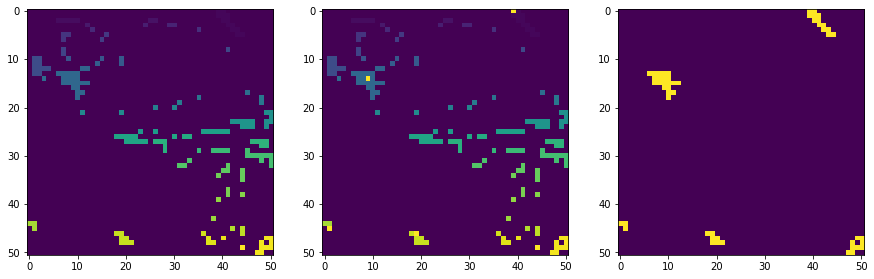

In [116]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(level_labeled)
ax[1].imshow(level_labeled)
ax[1].imshow(np.ma.masked_less(represented_lmins*1,1),cmap='viridis_r')
ax[2].imshow(level_objects)

In [117]:
lmin_mask = np.ma.masked_greater(lmins_labeled,0).mask
level_masks = []
for level in np.unique(mask_sum)[1:]:
    level_mask = np.ma.masked_equal(mask_sum,level).mask

    level_labeled = ndi.label(level_mask*1)[0]

    level_objects = np.zeros_like(level_mask)

    # check, which local minima are located within objects at this level
    represented_lmins = lmin_mask & level_mask

    retained_objects = level_labeled[np.where(represented_lmins==True)]

    for ro in retained_objects:
        level_objects[np.where(level_labeled==ro)]=1

    level_masks.append(level_objects)

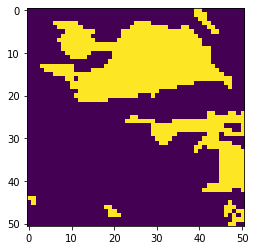

In [118]:
plt.imshow(np.sum(level_masks,axis=0))

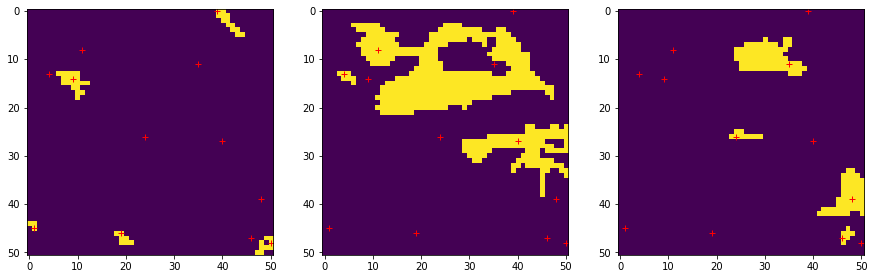

In [119]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for i,lvm in enumerate(level_masks):
    ax[i].imshow(lvm)
    
    for label in lmin_properties.keys():
        ax[i].plot(lmin_properties[label]['row'],
                   lmin_properties[label]['column'],'r+')

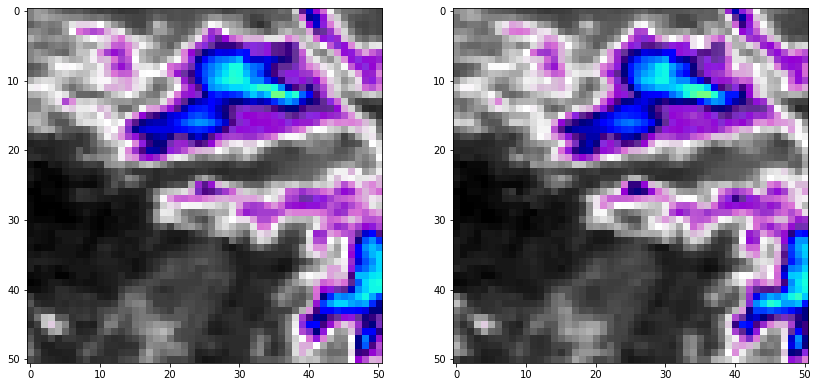

In [63]:
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].imshow(example_case['ir108'][8],vmin=210,vmax=300,cmap=emap)
ax[1].imshow(example_case['ir108'][9],vmin=210,vmax=300,cmap=emap)

Das sieht doch bis auf ein paar Objektteilungen und ganz vernünftig aus.

Als nächstes müssten wir durch alle Zeitschritte laufen und sehen, wie der Nachfolger im nächsten Schritt aussieht.

In [64]:
def link_objects(object_connections):

    tracks = []

    visited_oids = []
    for tid in object_connections.keys():
        for oid in object_connections[tid].keys():
            if oid in visited_oids:
                continue
            else:
                track = [oid]

                t = int(oid.split("_")[0])

                while t < len(object_connections.keys()):
                    try: 
                        oid = object_connections[t][oid][0]
                        track.append(oid)
                        visited_oids.append(oid)

                        t = int(oid.split("_")[0])
                    except:
                        break
                tracks.append(track)

    return tracks

In [65]:
len(objects_ws)

13

In [66]:
object_connections = {}

for i in range(1,len(objects_ws)):
    object_connections[i-1] = ot.find_successor_lakshmanan(objects_ws[i-1],objects_ws[i],i-1,i,2)

In [67]:
object_connections

{0: {'000_0001': ['001_0001'],
  '000_0002': ['001_0002'],
  '000_0003': ['001_0003'],
  '000_0004': ['001_0004'],
  '000_0005': ['001_0005'],
  '000_0006': ['001_0006'],
  '000_0007': ['001_0007'],
  '000_0008': ['001_0008']},
 1: {'001_0001': ['002_0001'],
  '001_0002': ['002_0002'],
  '001_0003': ['002_0003'],
  '001_0004': ['002_0004'],
  '001_0005': ['002_0005'],
  '001_0006': ['002_0006'],
  '001_0007': ['002_0007'],
  '001_0008': ['002_0008']},
 2: {'002_0001': ['003_0001'],
  '002_0003': ['003_0002'],
  '002_0004': ['003_0003'],
  '002_0005': ['003_0004'],
  '002_0006': ['003_0005'],
  '002_0007': ['003_0007']},
 3: {'003_0001': ['004_0001'],
  '003_0002': ['004_0002'],
  '003_0004': ['004_0003'],
  '003_0005': ['004_0004'],
  '003_0006': ['004_0005'],
  '003_0007': ['004_0006']},
 4: {'004_0001': ['005_0001'],
  '004_0002': ['005_0001'],
  '004_0003': ['005_0004'],
  '004_0004': ['005_0005'],
  '004_0005': ['005_0006'],
  '004_0006': ['005_0007']},
 5: {'005_0001': ['006_0001'

In [68]:
tracks = link_objects(object_connections)

In [69]:
tracks

[['000_0001',
  '001_0001',
  '002_0001',
  '003_0001',
  '004_0001',
  '005_0001',
  '006_0001',
  '007_0001'],
 ['000_0002', '001_0002', '002_0002'],
 ['000_0003',
  '001_0003',
  '002_0003',
  '003_0002',
  '004_0002',
  '005_0001',
  '006_0001',
  '007_0001'],
 ['000_0004', '001_0004', '002_0004', '003_0003'],
 ['000_0005',
  '001_0005',
  '002_0005',
  '003_0004',
  '004_0003',
  '005_0004',
  '006_0004',
  '007_0005',
  '008_0004',
  '009_0006',
  '010_0006',
  '011_0007',
  '012_0008'],
 ['000_0006',
  '001_0006',
  '002_0006',
  '003_0005',
  '004_0004',
  '005_0005',
  '006_0005',
  '007_0005',
  '008_0004',
  '009_0006',
  '010_0006',
  '011_0007',
  '012_0008'],
 ['000_0007',
  '001_0007',
  '002_0007',
  '003_0007',
  '004_0006',
  '005_0007',
  '006_0007',
  '007_0007',
  '008_0006',
  '009_0008',
  '010_0008',
  '011_0009',
  '012_0010'],
 ['000_0008', '001_0008', '002_0008'],
 ['003_0006',
  '004_0005',
  '005_0006',
  '006_0006',
  '007_0006',
  '008_0005',
  '009_0007'

Jetzt müssen wir nur noch den richtigen Track finden.

In [80]:
np.unique(objects_ws[6])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [77]:
object_id = ot.get_wanted_object_id(objects_ws)

In [78]:
object_id

0

In [72]:
wanted_track = []

for track in tracks:
    if "{:03d}_{:04d}".format(13//2,object_id) in track:
        wanted_track = track

In [73]:
"{:03d}_{:04d}".format(13//2,object_id)

'006_0000'

In [55]:
wanted_track

['000_0008',
 '001_0010',
 '002_0008',
 '003_0009',
 '004_0008',
 '005_0005',
 '006_0006',
 '007_0007',
 '008_0007',
 '009_0008',
 '010_0012',
 '011_0011',
 '012_0013']

In [81]:
wanted_object = ot.get_wanted_object_field(objects_ws,wanted_track)

IndexError: index 0 is out of bounds for axis 0 with size 0

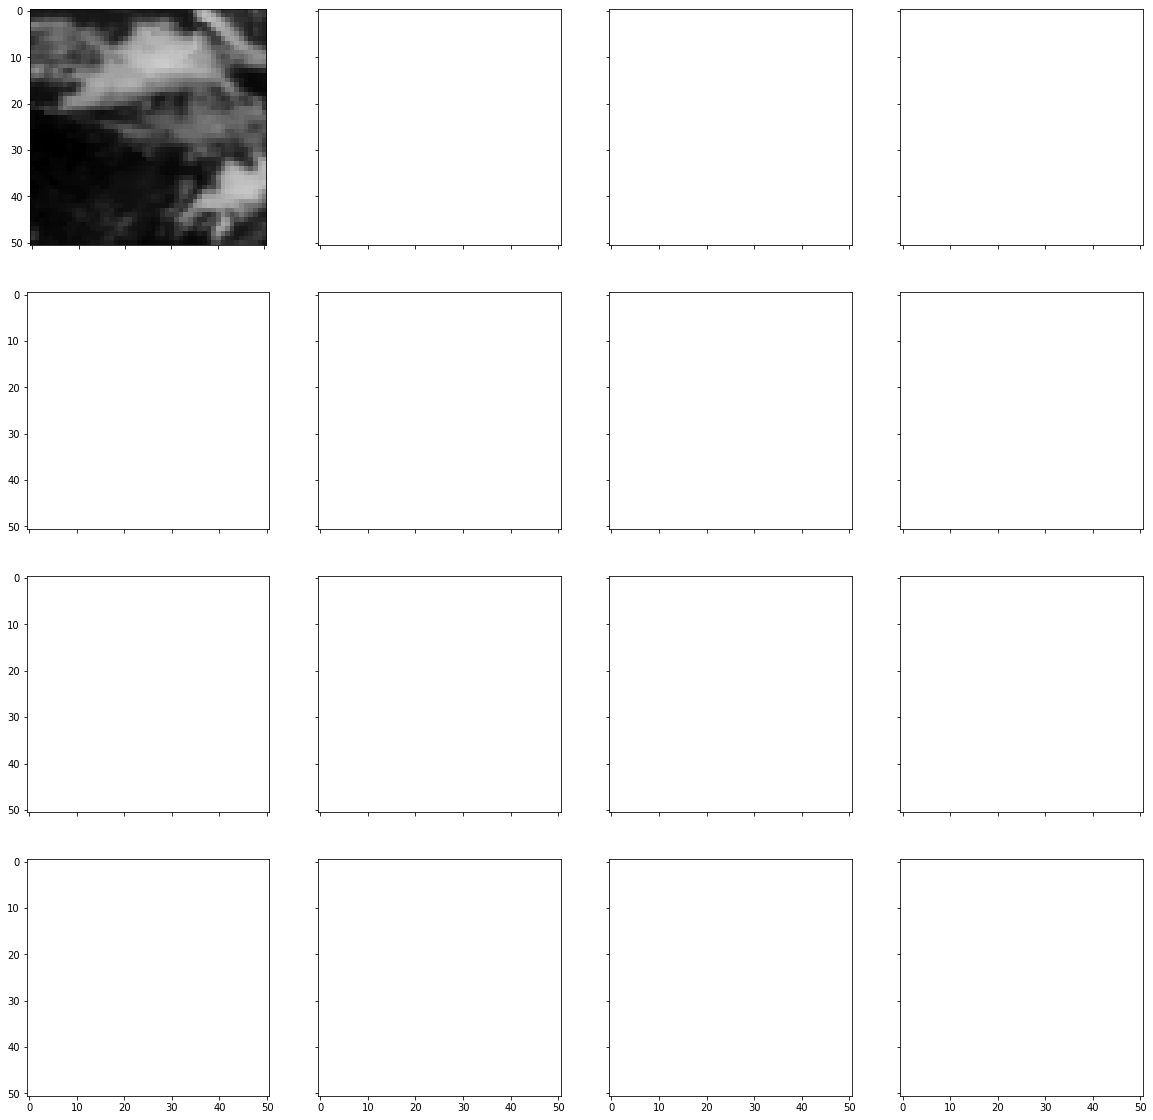

In [82]:
fig = plot_case_object(example_case,np.array(list(wanted_object.values())))

Dann können wir endlich Objekteigenschaften betrachten.

In [58]:
object_locations = dict()

for i,o in enumerate(wanted_object):
    object_locations[i] = np.where(wanted_object[i]==1)

In [59]:
values = []
times = []
field = []

for i in range(len(wanted_object)):
    for f in list(example_case.keys())[:15]:
        val = example_case[f][i][object_locations[i]]
        values.extend(val.tolist())
        
        times.extend([(i*5)-30]*len(val))
        field.extend([f]*len(val))

In [60]:
import pandas as pd
import seaborn as sns

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [61]:
case_df = pd.DataFrame({'value':values,'time':times,'field':field})

<Figure size 864x432 with 0 Axes>

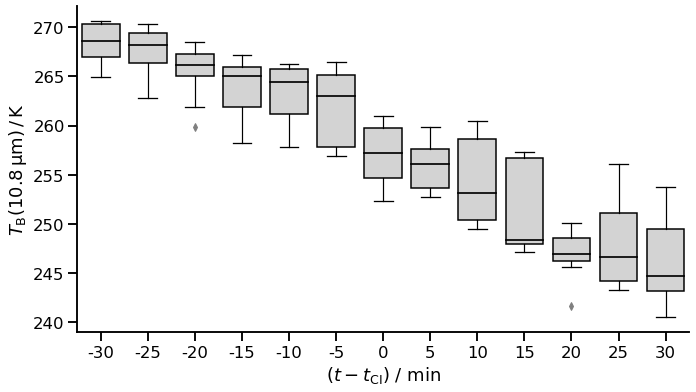

In [62]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

<Figure size 864x432 with 0 Axes>

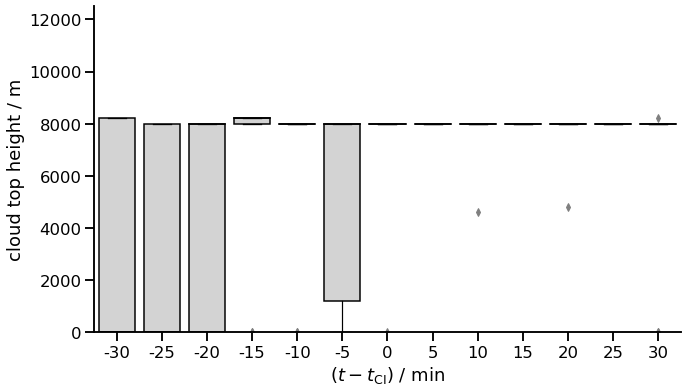

In [63]:
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ctth'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel("cloud top height / m")
plt.ylim(0,12500)
plt.gcf().set_size_inches(12, 6)

In [64]:
def simple_T2h(T,T0=288,dT=6.5):
    return -((T-T0) / dT) * 1000

In [65]:
medians = case_df[case_df.field=='ir108'].groupby('time').median()

Das ist doch ein durchaus schönes Objekt. Es wird nicht besonders kalt, aber es ist doch ein relativ typischer Lebenszyklus zu erkennen. Wir beginnen mit einem Objekt mit einem mittleren Temperatur von von ca. {{"{:4.0f}".format(medians.iloc[0].value)}}&thinsp;K und enden mit ca. {{"{:4.0f}".format(medians.iloc[12].value)}}&thinsp;K nach einer Stunde. Das entspricht bei einem adiabatischem tmeperaturprofil einem Wachstum der Wolkenoberkante von {{"{:4.0f}".format(simple_T2h(medians.iloc[0].value,293.15,10))}}&thinsp;m auf ca. {{"{:4.0f}".format(simple_T2h(medians.iloc[12].value,293.15,10))}}&thinsp;m in einer Stunde und somit einem mittleren Aufwind von $\overline{w} = 6.7\,\frac{\mathrm{m}}{\mathrm{s}}$. Das zeigen auch die Wolkenhöhendaten, wenn auch nicht sehr deutlich. Wir haben bereits zu Begin Pixel mit Höhen etwa 8000&thinsp;m, aber auch sehr niedrige Bereiche. Nach der Stunde sind im Objekt keine niedrigen Pixel mehr vorhanden.

Wir können auch versuchen nur einen Wert pro Zeitpunkt für das Objekt zu berechnen, um am Ende daraus relativ robuste Zeittrends zu berechnen, die nicht mehr von einem richtigen Feldtracking abhängig sind. Für die Infrarotkanäle bietet sich das Objektminimum an, da kälter höher und damit gefährlicher ist. Man könnte auch den Mittelwert aus den 10&thinsp;% kältesten Pixeln berechnen, um nicht von nur einem Pixelwert abhängig zu sein.

In [66]:
object_ir108_value = []

In [67]:
for t in case_df['time'].unique():
    case_subset = case_df[case_df['time'] == t]
    n_values = len(case_subset[case_subset['field'] == 'ir108'])
    
    if n_values < 15:
        object_ir108_value.append(case_subset[case_subset['field'] == 'ir108']['value'].min())
    else:
        values_sorted = sorted(case_subset[case_subset['field'] == 'ir108']['value'])
        
        object_ir108_value.append(np.mean(values_sorted[:int(np.rint(n_values/10))]))

In [68]:
def aggregate_object_values(object_values,field='ir108',fraction=10,function='min'):
    aggregated_values = []
    
    functions = {'min':np.min,
                 'max':np.max,
                 'mean':np.mean,
                 'median':np.median}
    
    for t in object_values['time'].unique():
        subset = object_values[object_values['time'] == t]
        n_values = len(subset[subset['field'] == field])

        if n_values < 15:
            aggregated_values.append(functions[function](subset[subset['field'] == field]['value']))
        else:
            values_sorted = sorted(case_subset[case_subset['field'] == 'ir108']['value'])
            
            if function == 'min':    
                aggregated_values.append(np.mean(values_sorted[:int(np.rint(n_values/fraction))]))
            elif function == 'max':
                aggregated_values.append(np.mean(values_sorted[-int(np.rint(n_values/fraction)):]))
            else: 
                aggregated_values.append(functions[function](subset[subset['field'] == field]['value']))
                
    return aggregated_values

In [69]:
object_ir108_value = aggregate_object_values(case_df,function='min')

<Figure size 864x432 with 0 Axes>

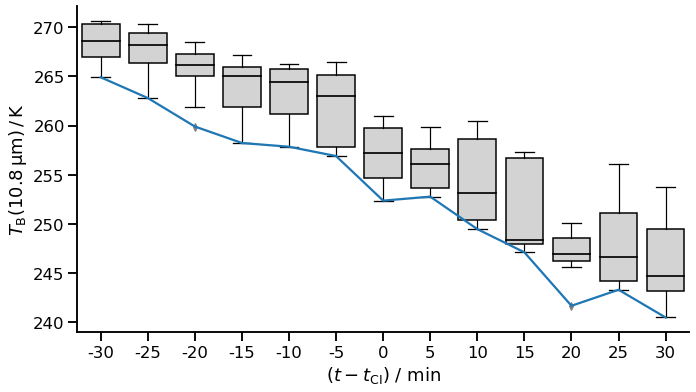

In [70]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_df[case_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

plt.plot(np.arange(0,13,1),object_ir108_value)

Nun sehen wir uns das für einen weiteren Fall an.


In [81]:
case = fio.read_nc_file(haci_cases[0])

In [82]:
sns.set_context("talk")

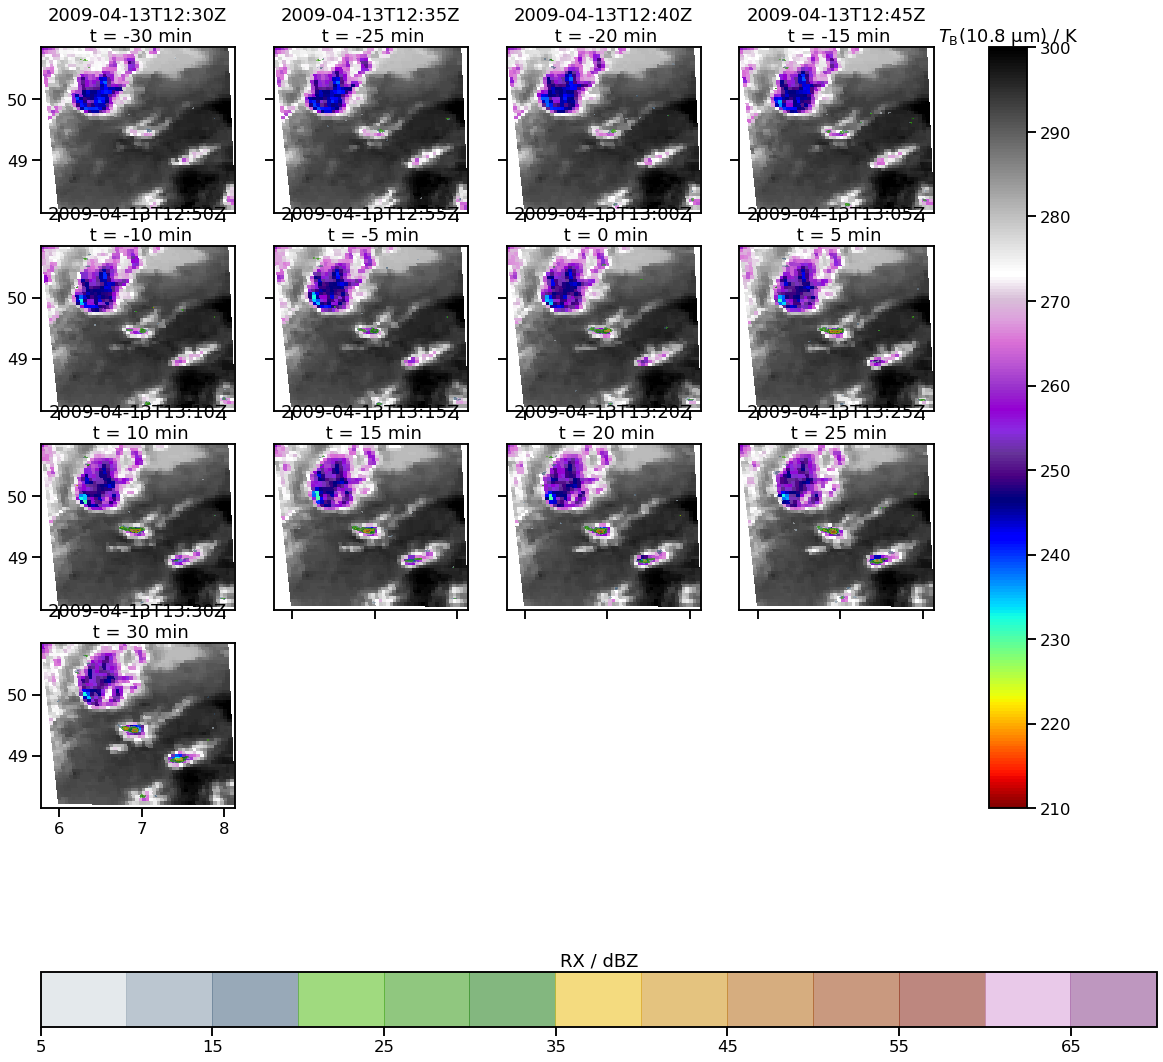

In [83]:
fig = plot_haci_case(case)

In [84]:
case

{'vis006': array([[[0.4026, 0.4094, 0.3866, ..., 0.1103, 0.1205, 0.1274],
         [0.3355, 0.3298, 0.3161, ..., 0.1035, 0.1023, 0.1001],
         [0.2775, 0.2468, 0.29  , ..., 0.0967, 0.1001, 0.0978],
         ...,
         [0.1421, 0.1387, 0.124 , ..., 0.3889, 0.5186, 0.5333],
         [0.1456, 0.1387, 0.1228, ..., 0.2274, 0.307 , 0.265 ],
         [0.1376, 0.1308, 0.141 , ..., 0.1001, 0.1149, 0.1069]],
 
        [[0.3832, 0.4014, 0.3946, ..., 0.1137, 0.1171, 0.1194],
         [0.3389, 0.3298, 0.3127, ..., 0.1058, 0.1058, 0.1035],
         [0.2877, 0.2468, 0.2866, ..., 0.0978, 0.0989, 0.0967],
         ...,
         [0.1376, 0.1319, 0.1217, ..., 0.3946, 0.3855, 0.3491],
         [0.1285, 0.1251, 0.1194, ..., 0.4424, 0.5151, 0.497 ],
         [0.1285, 0.1331, 0.1365, ..., 0.2979, 0.315 , 0.2684]],
 
        [[0.365 , 0.3764, 0.3741, ..., 0.1126, 0.1183, 0.1717],
         [0.3116, 0.2877, 0.3014, ..., 0.1058, 0.1058, 0.1296],
         [0.2911, 0.2343, 0.2923, ..., 0.0967, 0.1012, 0.094

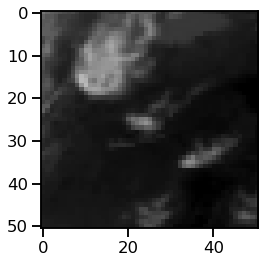

In [79]:
plt.imshow(case['ir108'][6],vmin=210,vmax=300,cmap='gray_r')

In [85]:
objects, object_tracks = ot.track_objects_lmin_cost(case['ir108'],6,220,273.15,240,5,search_factor=3)

ValueError: `mask` (shape ()) must have same shape as `image` (shape (51,))

TypeError: Invalid shape (51,) for image data

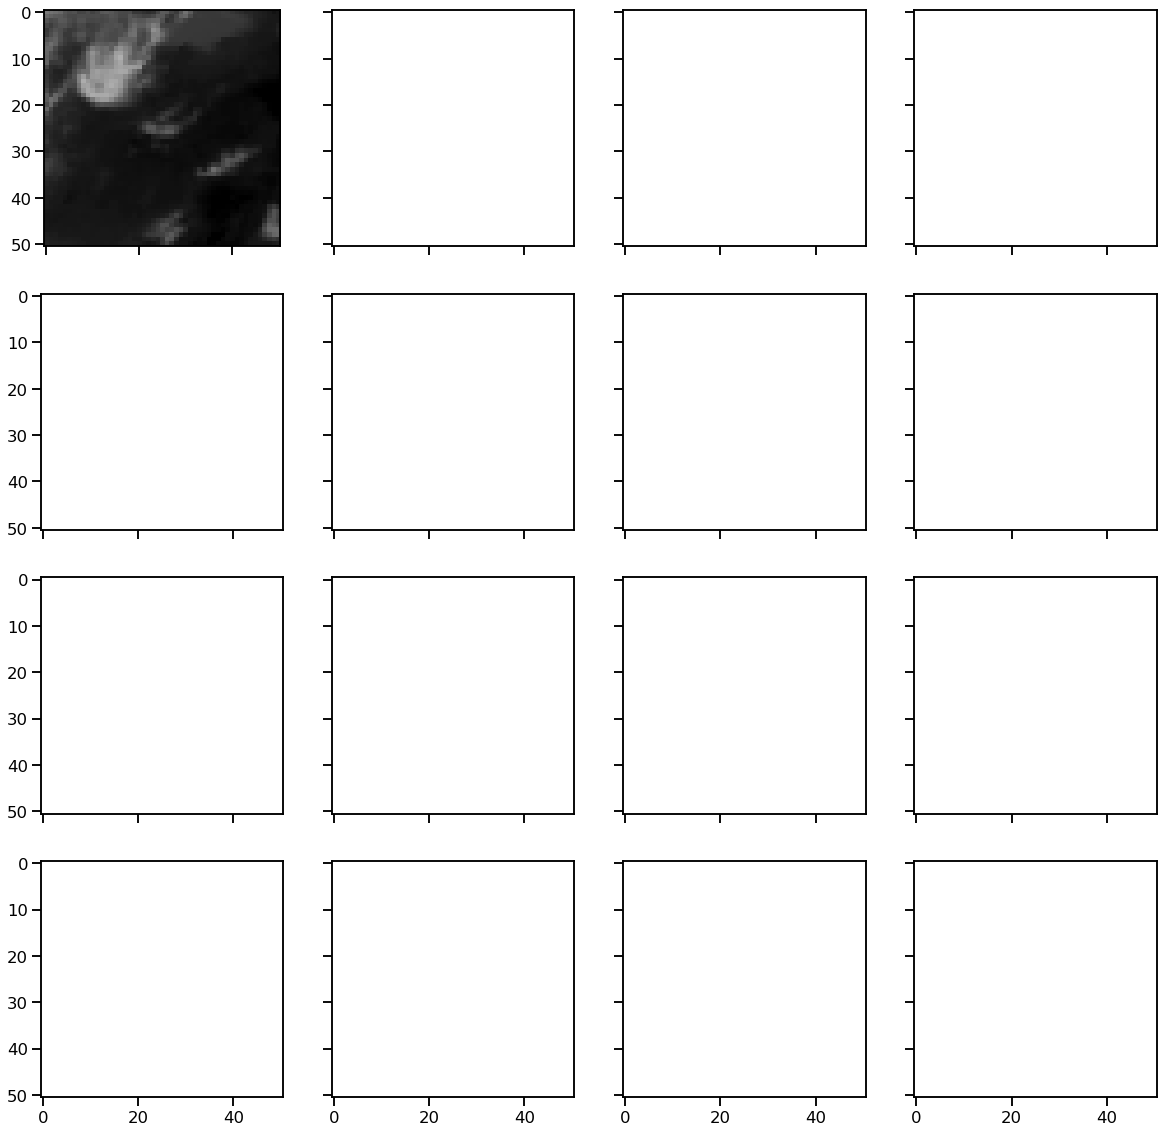

In [80]:
fig = plot_case_object(case,objects)

In [ ]:
wanted_object_id = ot.get_wanted_object_id(objects)

In [ ]:
wanted_track = ot.select_wanted_track_from_list(object_tracks,"{:03d}_{:04d}".format(len(objects)//2,wanted_object_id))

In [ ]:
track_field = ot.get_wanted_object_field(objects,wanted_track)

In [ ]:
fig = plot_case_object(case,np.array(list(track_field.values())))

Das sieht auch gut aus!

In [ ]:
object_locations = dict()

for i,o in enumerate(track_field):
    object_locations[i] = np.where(track_field[i]==1)
    
values = []
times = []
field = []

for i in range(len(wanted_object)):
    for f in list(case.keys())[:15]:
        val = case[f][i][object_locations[i]]
        values.extend(val.tolist())
        
        times.extend([(i*5)-30]*len(val))
        field.extend([f]*len(val))

In [ ]:
case_value_df = pd.DataFrame({'value':values,
                              'time':times,
                              'field':field})

In [ ]:
object_ir108_value = aggregate_object_values(case_value_df,function='min')
object_ir108_mean = aggregate_object_values(case_value_df,function='mean')

In [ ]:
sns.set_context("talk")
plt.figure(figsize=(12,6))

sns.catplot(x='time',
            y='value',
            data=case_value_df[case_value_df['field']=='ir108'],
            kind='box',
            color='lightgray',
            boxprops = {'edgecolor': 'k',
                        'linewidth': 1.5},
            medianprops = {'color': 'k',
                           'linewidth': 1.7},
            whiskerprops = {'color': 'k', 
                            'linewidth': 1.2},
            capprops = {'color': 'k',
                        'linewidth': 1.3})
plt.xlabel(r"$\left(t - t_\mathrm{CI} \right)$ / min")
plt.ylabel(r"$T_\mathrm{B} (10.8\,$µm$)\,/\,\mathrm{K}$")
plt.gcf().set_size_inches(12, 6)

plt.plot(np.arange(0,13,1),object_ir108_value)

Das ist auch kein Fall mit besonders starker Konvektion. Aber es findet ein Wachstum der Wolke statt. Zu Beginn des Zeitausschnittes hat das Objekt eine mittlere Helligkeitstemperatur von etwa <i>T</i><sub>B</sub>={{"{:4.0f}".format(object_ir108_mean[0])}}&thinsp;K und nach einer Stunde von <i>T</i><sub>B</sub>={{"{:4.0f}".format(object_ir108_mean[-1])}}&thinsp;K. Entsprechend ergibt sich ein mittlerer Temperaturunterschied von &Delta;T&thinsp;=&thinsp;{{"{:4.0f}".format(object_ir108_mean[-1] - object_ir108_mean[0])}}&thinsp;K&thinsp;&middot;&thinsp;h<sup>-1</sup>. Das enspricht bei einem atmosphötischen Temperaturgradienten von d<i>T</i> = 6,5&thinsp;K&thinsp;km<sup>-1</sup> und <i>T</i><sub>Boden</sub>&thinsp;=&thinsp;293,95&thinsp;K einer mittleren Wolkenhöhe von h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[0],293.15,6.5))}}&thinsp;m und h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[-1],293.15,6.5))}}&thinsp;m und einem mittleren Höhenwachstum von &Delta;h&thinsp;=&thinsp;{{"{:4.0f}".format(simple_T2h(object_ir108_mean[-1],293.15,6.5) - simple_T2h(object_ir108_mean[0],293.15,6.5))}}&thinsp;m&thinsp;&middot;&thinsp;h<sup>-1</sup>. Das entspricht einer grob geschätzten mittleren Aufwindgeschwindigeit von $\overline{w} =$&thinsp;{{"{:4.0f}".format((simple_T2h(object_ir108_mean[-1],293.15,6.5) - simple_T2h(object_ir108_mean[0],293.15,6.5))/360)}}&thinsp;m&thinsp;&middot;&thinsp;s<sup>-1</sup>, was durchaus im stärkeren Aufwindbereich anzusiedeln ist.